In [1]:
%load_ext autoreload
%autoreload 2

from plonk.pipe import PlonkPipeline
from PIL import Image
import torch
device = torch.device("cuda")

/home/dufour/miniconda3/envs/plonk_release/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_path = ".media/condor_2.jpg"
image = Image.open(image_path)
pipeline = PlonkPipeline("nicolas-dufour/PLONK_iNaturalist").to(device)

Using cache found in /home/dufour/.cache/torch/hub/facebookresearch_dinov2_main
/home/dufour/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/dufour/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/dufour/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
gps_coords = pipeline(image, batch_size=1024)

/home/dufour/Documents/plonk/plonk/models/samplers/riemannian_flow_sampler.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):


In [4]:
latitude, longitude, likelihood = pipeline.compute_likelihood_grid(image, grid_resolution_deg=1, batch_size=4096, cfg=0)

Computing likelihood over a 181x361 grid (65341 points)...


Computing Likelihood Grid:   0%|          | 0/16 [00:00<?, ?it/s]

Computing Likelihood Grid:   6%|▋         | 1/16 [00:34<08:44, 34.98s/it]

Likelihood NFE: 1136


Computing Likelihood Grid:  12%|█▎        | 2/16 [01:10<08:17, 35.54s/it]

Likelihood NFE: 1160


Computing Likelihood Grid:  19%|█▉        | 3/16 [01:49<08:00, 36.99s/it]

Likelihood NFE: 1244


Computing Likelihood Grid:  25%|██▌       | 4/16 [02:27<07:27, 37.32s/it]

Likelihood NFE: 1202


Computing Likelihood Grid:  31%|███▏      | 5/16 [03:07<07:00, 38.26s/it]

Likelihood NFE: 1268


Computing Likelihood Grid:  38%|███▊      | 6/16 [03:42<06:13, 37.32s/it]

Likelihood NFE: 1142


Computing Likelihood Grid:  44%|████▍     | 7/16 [04:21<05:39, 37.74s/it]

Likelihood NFE: 1244


Computing Likelihood Grid:  50%|█████     | 8/16 [04:59<05:03, 37.95s/it]

Likelihood NFE: 1226


Computing Likelihood Grid:  56%|█████▋    | 9/16 [05:39<04:29, 38.53s/it]

Likelihood NFE: 1262


Computing Likelihood Grid:  62%|██████▎   | 10/16 [06:19<03:53, 38.96s/it]

Likelihood NFE: 1268


Computing Likelihood Grid:  69%|██████▉   | 11/16 [06:59<03:16, 39.27s/it]

Likelihood NFE: 1274


Computing Likelihood Grid:  75%|███████▌  | 12/16 [07:39<02:38, 39.53s/it]

Likelihood NFE: 1274


Computing Likelihood Grid:  81%|████████▏ | 13/16 [08:20<01:59, 39.85s/it]

Likelihood NFE: 1310


Computing Likelihood Grid:  88%|████████▊ | 14/16 [08:58<01:18, 39.27s/it]

Likelihood NFE: 1214


Computing Likelihood Grid:  94%|█████████▍| 15/16 [09:35<00:38, 38.76s/it]

Likelihood NFE: 1202


Computing Likelihood Grid: 100%|██████████| 16/16 [10:09<00:00, 38.10s/it]

Likelihood NFE: 1118


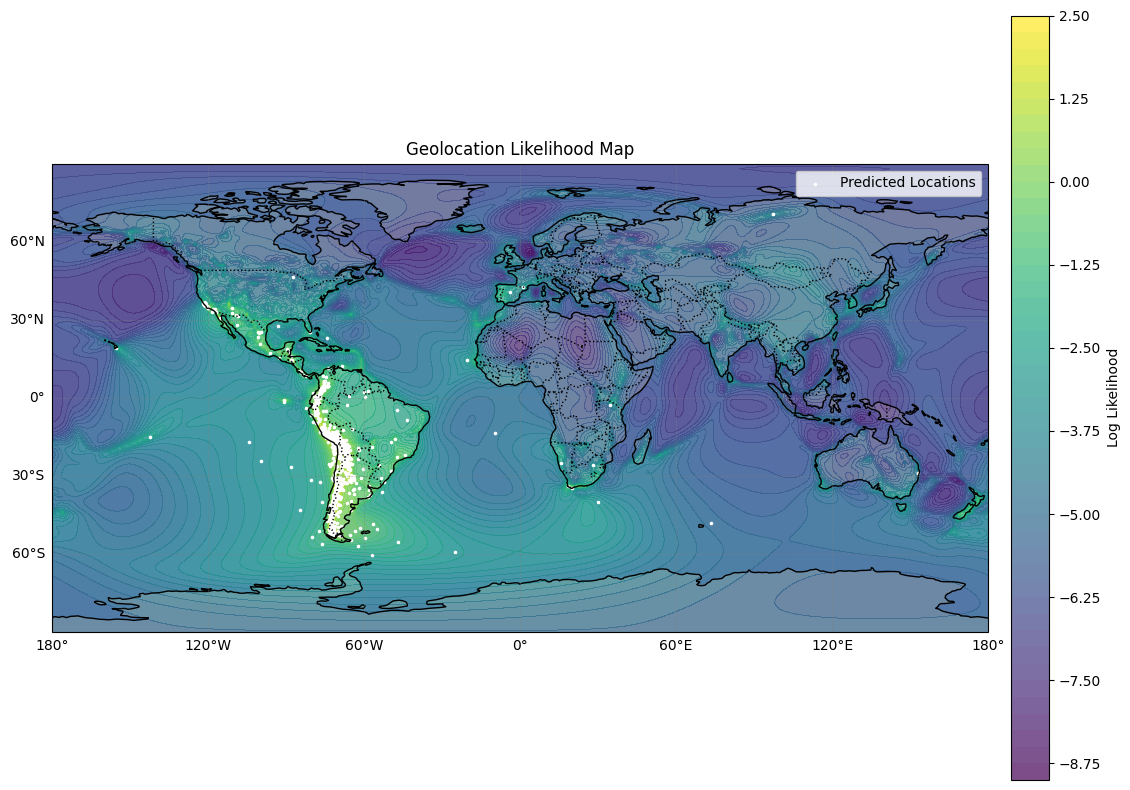

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize

# Create a figure with a map projection
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Create a mesh grid for the contour plot
lon_mesh, lat_mesh = np.meshgrid(longitude, latitude)

# Normalize the likelihood values for better visualization
# Higher values should be more prominent
norm = Normalize(vmin=likelihood.min(), vmax=likelihood.max())

# Create a filled contour plot of the likelihood values
contour = ax.contourf(lon_mesh, lat_mesh, likelihood, 
                      transform=ccrs.PlateCarree(),
                      cmap='viridis', norm=norm, levels=50, alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Log Likelihood')

# Mark the predicted GPS coordinates
ax.scatter(gps_coords[:, 1], gps_coords[:, 0], 
           color='white', marker='.', s=10, 
           transform=ccrs.PlateCarree(), 
           label='Predicted Locations')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title and legend
plt.title('Geolocation Likelihood Map')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [17]:
# Compute localizability
localizability = pipeline.compute_localizability(image)
print(f"Localizability: {localizability}")

Likelihood NFE: 362
Localizability: 0.350289523601532
